In [314]:
#Importing modules
import os

#data
import numpy as np
import pandas as pd
import random as rn

#work with images
import cv2   

#visualizing
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec

#model selection
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.decomposition import PCA

#cnn 
import keras
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from keras.regularizers import l2                         # L2-regularisation
from keras.layers.normalization import BatchNormalization # batch normalisation

from keras.callbacks import Callback




In [315]:
#Global variables

#CNN Training
batch_size=128    # in each iteration, we consider 128 training examples at once
epochs=50         # we iterate 50 times over the entire training set
l2_lambda = 0.0001             # L2 regularization param

#Image
target_image_size = (150,150)      # resize input images to that size
shape = target_image_size + (3,)   # RGB

#data sets
path_to_train_images = 'train'  # directory with training images
path_to_test_images = 'test'    # directory with testing images

class_names = os.listdir(path_to_train_images) # list of possible classes
class_count = len(class_names)
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [316]:
#Supported functions

#Crop image to get square aspect ratio
#If not rectangle - get rectangle from image center
def crop(image):
    height, width, channels = image.shape
    if (width==height):
        return image
    
    half_height = (int)(height * 0.5)
    half_width = (int)(width * 0.5)
    if (width > height):
        return image[0:height, half_width-half_height:half_width+half_height]
    
    #height < width
    return image[half_height-half_width:half_height+half_width, 0:width]

In [317]:
# Preporce source image: histogram equalization, crop and resize to smaller size
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  #Supports only grayscale images, so need to convert
    lab_planes = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    # Contrast Limited Adaptive Histogram Equalization
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes) 
    
    bgrImage = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    croppedImage = crop(bgrImage)
    resizedImage = cv2.resize(croppedImage, target_image_size, interpolation=cv2.INTER_AREA)
    return resizedImage


In [318]:
#Loading images from 'path' folder for 'flower_type' class to x and z arrays
#'step', 'totalStep' are used for progress
def load_images(flowerType, path, x,z, step, totalStep):
    dir_path = os.path.join(path, flowerType)
    files = os.listdir(dir_path)   # get all images from folder
    files_count = len(files)
    for index, img in enumerate(files):
        path = os.path.join(dir_path,img)   #get filePath
        
        img = cv2.imread(path,cv2.IMREAD_COLOR) #read image as it is
        img = preprocess_image(img)    

        arrayImg = np.array(img)
        
        x.append(arrayImg)
        z.append(flowerType)
        print("\rLoading images. Class: {}. Step {}/{}. File {} of {}".format(flowerType, step, totalStep,index+1,files_count), end="")    

In [319]:
#Encoding label from text to numbers, One-hot encoding
# (daisy-> 0, dandelion->1 etc...)
def encode_Y_label(le, z):
    temp_y = le.fit_transform(z)
    return keras.utils.to_categorical(temp_y, class_count)    # One-hot encode the labels

#Decoding Label from number to text for confusion matrix
def decode_Y_label(soft_vals):
    result = np.zeros_like(soft_vals)
    result[np.arange(len(soft_vals)), soft_vals.argmax(1)] = 1
    return result

In [320]:
#Loading training images

x_train=[]
z_train=[]

x_test=[]
z_test=[]

totalClasses = len(class_names);
for index,val in enumerate(class_names):
    load_images(val,path_to_train_images, x_train,z_train, index+1, totalClasses)
    print('')
print("\rTraining images loaded.")

print('')
for index,val in enumerate(class_names):
    load_images(val,path_to_test_images, x_test,z_test, index+1, totalClasses)
    print('')
print("\rTesting images loaded.")

Loading images. Class: daisy. Step 1/5. File 615 of 615
Loading images. Class: dandelion. Step 2/5. File 841 of 841
Loading images. Class: rose. Step 3/5. File 627 of 627
Loading images. Class: sunflower. Step 4/5. File 587 of 587
Loading images. Class: tulip. Step 5/5. File 787 of 787
Training images loaded.

Loading images. Class: daisy. Step 1/5. File 150 of 150
Loading images. Class: dandelion. Step 2/5. File 209 of 209
Loading images. Class: rose. Step 3/5. File 155 of 155
Loading images. Class: sunflower. Step 4/5. File 147 of 147
Loading images. Class: tulip. Step 5/5. File 187 of 187
Testing images loaded.


In [395]:
#Create y array
y_train = []
y_test = []

le=preprocessing.LabelEncoder()
y_train = encode_Y_label(le,z_train);
y_test = encode_Y_label(le, z_test);

print(y_train)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [322]:
#Visual styles of showed images

def customize_Visualization(ax):
         # remove spinse
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

        ## remove tick
    ax.tick_params(bottom="off", left="off")
    ax.set_yticklabels([])
    ax.set_xticklabels([])



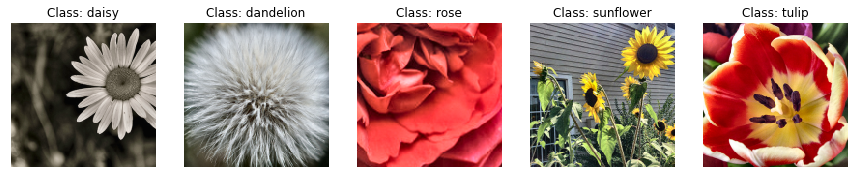

In [323]:
#Visualize random train images

fig,ax=plt.subplots(1, class_count, gridspec_kw = {'wspace':0.2, 'hspace':0.2})   #plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(15,15)

for i in range(class_count):
    classifiedImages = [x for x in range(len(y_train)) if y_train[x][i]==1]

    rnd = rn.randint(0,len(classifiedImages))
    random_Image_Index = classifiedImages[rnd]
    img2 = cv2.cvtColor(x_train[random_Image_Index], cv2.COLOR_BGR2RGB)
    ax[i].imshow(img2)
    ax[i].set_title('Class: '+z_train[random_Image_Index])
    
    customize_Visualization(ax[i])
        
plt.show()
plt.close()
        

In [324]:
def encode_X_label(x):
    temp_x = np.array(x);
    temp_x = temp_x / 255     # Normalise data to [0, 1] range
    
    return temp_x

In [393]:
#Normalize data
x_train = encode_X_label(x_train);
x_test = encode_X_label(x_test);

array([[[[7.38177624e-04, 9.38100730e-04, 9.07343329e-04],
         [7.07420223e-04, 9.07343329e-04, 9.07343329e-04],
         [7.38177624e-04, 9.38100730e-04, 9.22722030e-04],
         ...,
         [8.45828527e-04, 1.04575163e-03, 8.45828527e-04],
         [8.76585928e-04, 1.06113033e-03, 8.76585928e-04],
         [8.61207228e-04, 1.03037293e-03, 8.76585928e-04]],

        [[7.53556324e-04, 9.68858131e-04, 9.53479431e-04],
         [7.07420223e-04, 9.22722030e-04, 9.07343329e-04],
         [7.53556324e-04, 9.68858131e-04, 9.38100730e-04],
         ...,
         [8.76585928e-04, 1.07650903e-03, 8.91964629e-04],
         [8.61207228e-04, 1.04575163e-03, 8.61207228e-04],
         [9.22722030e-04, 1.09188774e-03, 9.53479431e-04]],

        [[7.38177624e-04, 9.38100730e-04, 9.22722030e-04],
         [7.38177624e-04, 9.53479431e-04, 9.38100730e-04],
         [7.68935025e-04, 9.84236832e-04, 9.53479431e-04],
         ...,
         [8.61207228e-04, 1.06113033e-03, 8.76585928e-04],
         [

In [326]:
# Splitting into Training and Validation Sets

x_train,x_validation,y_train,y_validation=model_selection.train_test_split(x_train,y_train,test_size=0.15,random_state=13)

In [327]:
# Conv
def get_model1():
    
    inp = Input(shape=shape)
    input_norm = BatchNormalization()(inp)
    
    conv1 = Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                       kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), activation ='relu')(input_norm)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Convolution2D(filters =64, kernel_size = (3,3),padding = 'Same',
                              kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), activation ='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)
    pool2 = BatchNormalization()(pool2)
 
    
    conv3 = Convolution2D(filters =64, kernel_size = (3,3),padding = 'Same', 
                             kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda), activation ='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)
    pool3 = BatchNormalization()(pool3)
        
    conv4 = Convolution2D(filters =96, kernel_size = (3,3),padding = 'Same', 
                             kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda), activation ='relu')(pool3)
    pool4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv4)
    pool4 = BatchNormalization(axis=1)(pool4)
    
    conv5 = Convolution2D(filters =96, kernel_size = (3,3),padding = 'Same', 
                             kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda), activation ='relu')(pool4)
    pool5 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv5)
    pool5 = BatchNormalization()(pool5)
    
    conv6 = Convolution2D(filters =32, kernel_size = (3,3),padding = 'Same', 
                             kernel_initializer='he_uniform',kernel_regularizer=l2(l2_lambda), activation ='relu')(pool5)
    pool6 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv6)
    pool6 = BatchNormalization()(pool6)
    drop1 = Dropout(0.2)(pool6)

    flat = Flatten()(drop1)
    hidden = Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda), activation='relu')(flat)
    
    out = Dense(class_count, kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_lambda), activation = "softmax")(hidden)
    
    return Model(inputs=inp, outputs=out)


In [328]:
#Колбэк для сбора статистики

class CustomCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_train_begin(self,logs={}):
        self.train_loss = []
        self.val_loss = []
    def on_epoch_end(self, epoch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        
      #  x, y = self.test_data                                     # check on testing data
      #  loss, acc = self.model.evaluate(x, y, verbose=0)
      #   print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [329]:
model=get_model1()   
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 64)        0         
__________

In [330]:
#Data Augmentation

datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally
        height_shift_range=0.2,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,    # randomly flip images
        brightness_range=[0.6, 1.3])   #change brighness of image 

datagen.fit(x_train)

In [331]:
#Load precalculated weights
def LoadWeights():
    model.load_weights('50_epochs.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [363]:
#Model training

calbacks = [
CustomCallback((x_test,y_test)),
#keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
keras.callbacks.ModelCheckpoint('50_epochs.h5', save_best_only=True)
]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              steps_per_epoch=(x_train.shape[0] / float(batch_size)), epochs = epochs, 
                              validation_data = (x_validation,y_validation),verbose = 1,
                              callbacks=calbacks)
   # always save your weights after training or during training. Model_checkpoint это и делает.

Epoch 1/50
17/22 [=====================>........] - ETA: 1:01 - loss: 0.8081 - acc: 0.7619

KeyboardInterrupt: 

In [332]:
# Keras reported accuracy:

metrics = model.evaluate(
        x=x_test,
        y=y_test,
        batch_size=batch_size,
        verbose=1,
        sample_weight=None
    )
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(metrics[0], metrics[1]))

848/848 [==============================] - 21s 25ms/step
Loss: 0.773, Accuracy: 0.784


In [364]:

y_pred = decode_Y_label(y_pred)


y_classes1 = [np.argmax(y, axis=None, out=None) for y in y_test]
y_classes2 = [np.argmax(y, axis=None, out=None) for y in y_pred]


confusion_matrix(y_classes1, y_classes2)

array([[117,  15,   9,   2,   7],
       [  9, 171,   6,  14,   9],
       [  1,   3, 116,   3,  32],
       [  1,   9,   5, 122,  10],
       [  4,  11,  29,   4, 139]], dtype=int64)

In [384]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
  #  plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


    thresh = cm.max() / 1.5 if normalize else (cm.max() / 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Real flower')
    plt.xlabel('Predicted flower\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

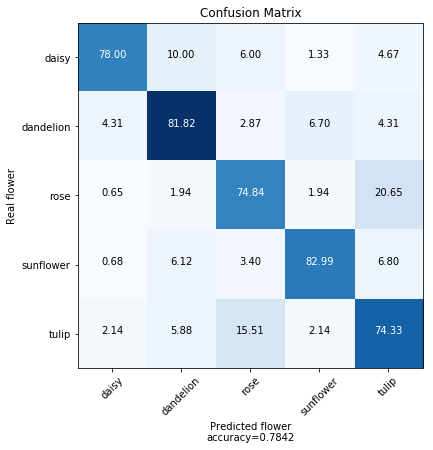

In [385]:
plot_confusion_matrix(cm           = confusion_matrix(y_classes1, y_classes2), 
                      normalize    = True,
                      target_names = class_names,
                      title        = "Confusion Matrix")

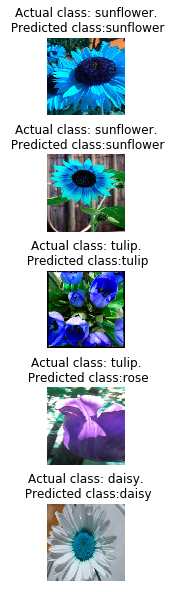

[0]


In [181]:
#make some predictions

#Visualize random train images

fig,ax=plt.subplots(class_count,1, gridspec_kw = {'wspace':0.2, 'hspace':0.5})   #plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(10,10)

for i in range(class_count):
    rnd = rn.randint(0,len(x_train))
    random_image = x_train[rnd]
    imgAsArray = image.img_to_array(random_image)
    imgAsArray = np.expand_dims(imgAsArray, axis=0)
    
    classes = model.predict_classes(imgAsArray, batch_size=batch_size)
    
    ax[i].imshow(random_image)
    ax[i].set_title('Actual class: '+z_train[rnd] + ".\n Predicted class:" + class_names[classes[0]])
    
    customize_Visualization(ax[i])
        
plt.show()
plt.close()


img = x_train[200]
images = np.vstack([x])

print(classes)

In [361]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

NameError: name 'History' is not defined

In [362]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

NameError: name 'History' is not defined